In [19]:
import os
import pandas as pd
import numpy as np

import wrangle as wr
import explore as ex
import model as md

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## Project Planning

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

- Create README.md with data dictionary, project and business goals, and come up with initial hypotheses.

- Acquire data from the Codeup Database and create a function to automate this process. 
- Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process. 
- Store the acquisition and preparation functions in a wrangle.py module function, and prepare data in Final Report Notebook by importing and using the function.
- Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- Establish a baseline accuracy and document well.
- Train 3 different regression models.
- Evaluate models on train and validate datasets.
- Choose the model that performs the best and evaluate that single model on the test dataset.
- Document conclusions, takeaways, and next steps in the Final Report Notebook.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Wrangling

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

In [20]:
df = wr.prep_zillow(wr.get_zillow())
df.head(2)
df.shape

(49899, 19)

##  Wrangling Takeaways
- Initially, a data frame consisting of 52,442 rows and 17 columns was pulled from the CodeUP database using SQL.
- Following the Data Acquisition the following preparation work was done to the acquired data:
   - Removed transaction dates after 12-31-2017 to ensure only 2017 transactions were pulled.
   - Mapped the 'county' column instead of the FIPS code to show the county names.
   - Filled any nans in the poolcnt,fireplacecnt, garagecarcnt columns with 0 to represent there being 0 of the features in the properties.
   - Dropped properties that were flagged as Tax Delinquent.
   - Dropped the 'taxdelinquencyflag' and 'propertylandusedesc' columns.
   - Renamed a handful of columns for better readability.
   - Dropped any remaining rows with null values from any columns in the DataFrame.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# TRAIN, VAL, TEST SPLIT

In [21]:
train, validate, test = wr.wrangle_zillow()

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# Data Exploration

- Prior to modeling i have asked some questions as well as make visulization and done statisitcals tests to answer my questions.


#### I'm going to start off by looking at the most commonly looked at features when looking for a house. Those being, bedrooms, bathrooms and square footage.

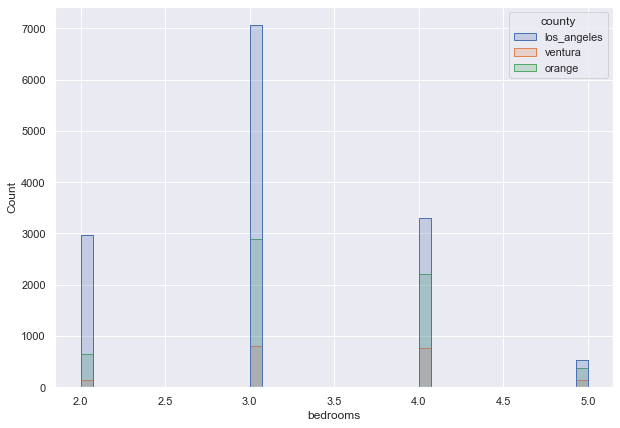

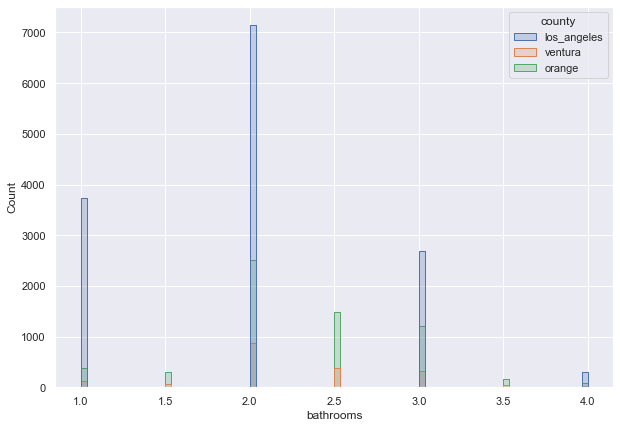

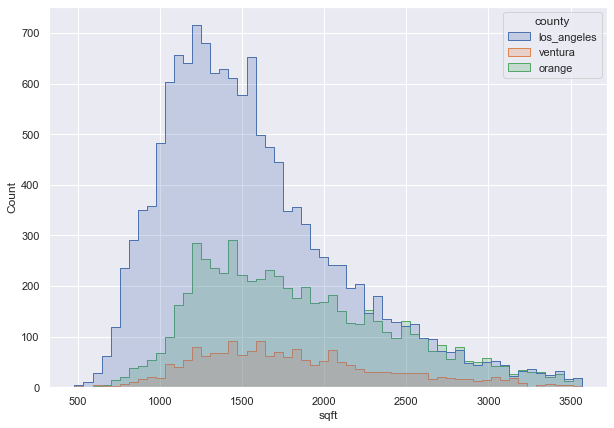

In [22]:
ex.plot_categorical_and_continuous_vars(train)

#### Takeaways
- We can see that Los Angeles has the most amount of properties out of all three counties.
- Along with this it has the highest average Sqft our of all three properties.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 1. How does the size of a property affect the price?

<Figure size 864x576 with 0 Axes>

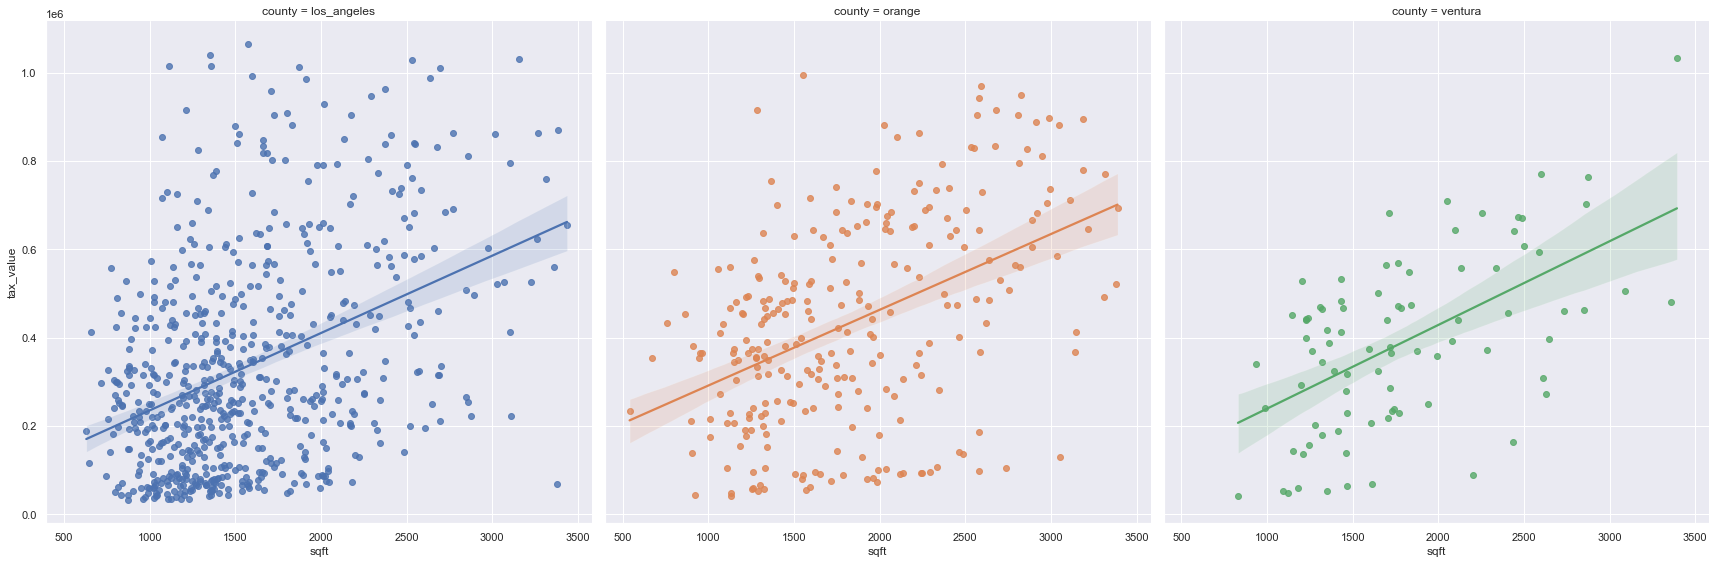

In [23]:
ex.zillow_lmplot(train)

#### Takeaways:
- Ventura shows the most normal correlation to sqft and housing prices with prices going up relative to acquiring more square footage.

- Los angeles however has a lot more houses that are higher than the average price yet relatively smaller in terms of square footage. 
    -  Perhaps this is due to location in the city affecting housing prices, i.e closer to richer parts of town.

#### Square footage statistical Testing
(H_0): ABOVE MEDIAN SQFT means LESS expensive than BELOW MEDIAN SQFT.\
(H_a): ABOVE MEDIAN SQFT means MORE expensive than BELOW MEDIAN SQFT.

In [24]:
ex.sqft_test(train)

Fail to reject the Null Hypothesis.
        
Properties that are ABOVE THE SQFT are LESS expensive than those BELOW MEDIAN SQFT.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 2. Which county has the most expensive properties on average?

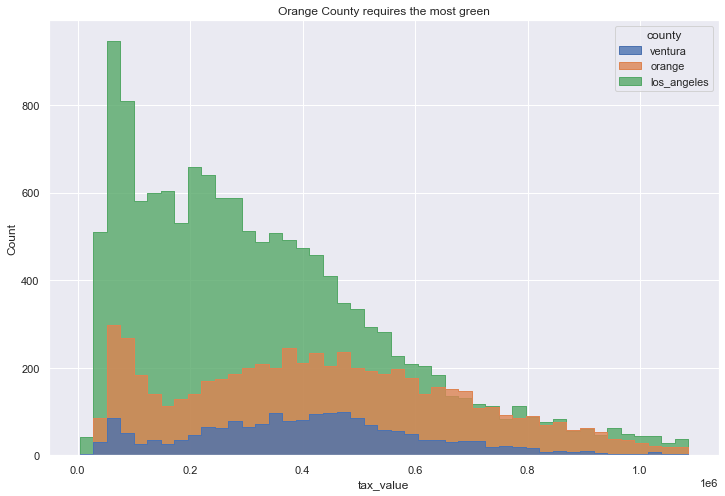

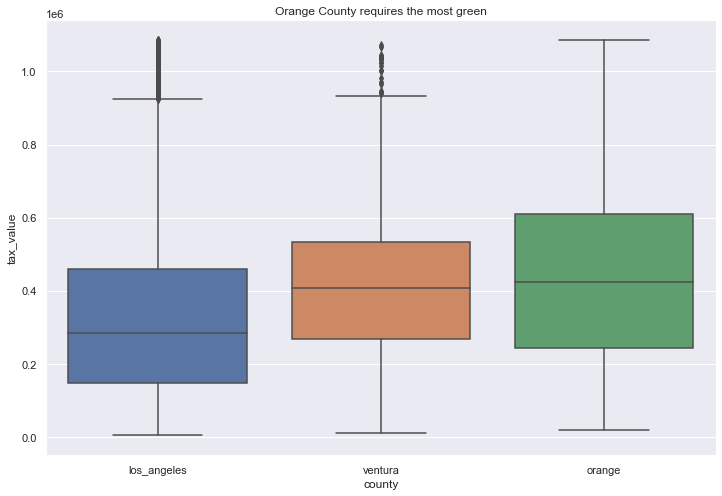

In [25]:
ex.county_value(train)

#### Takeaways
- Out of all three counties, Los Angeles has the cheapest average price for housing. This may be due to it having the most abundant amount of cheap housing in comparison to the other two counties.
- Orange County although the largest range of pricing still shows the highest average home price.

#### County Pricing Testing
(H_0): Homes in Los Angeles are MORE expensive than those in either Orange County and Ventura. \
(H_a): Homes in Los Angeles are LESS expensive than those in either Orange County and Ventura.

In [26]:
ex.county_test(train)

Fail to reject the Null Hypothesis.
        
Homes in Los Angeles are MORE expensive than those in either Orange County and Ventura.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 3. Do newer homes sell for more than older homes? 

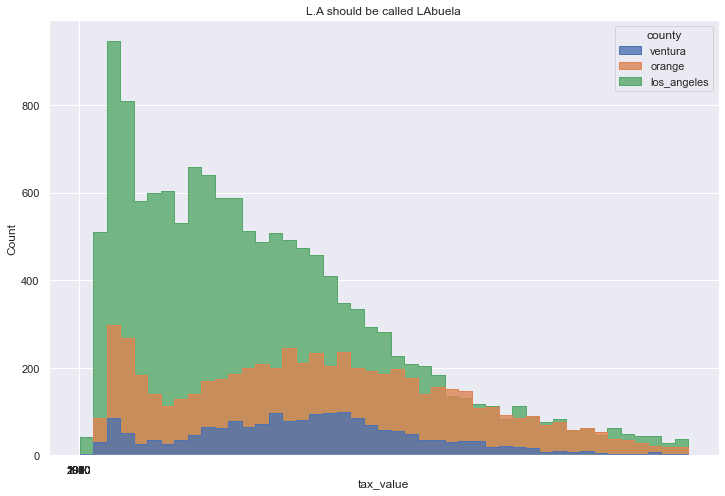

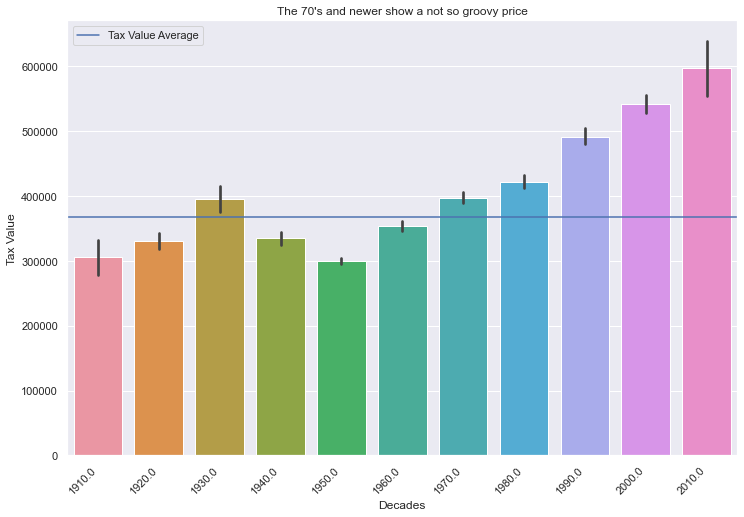

In [27]:
ex.yb_graph(train)

#### New(Before 1972) v. Old (After 1972) statistical testing
(H_0): Homes built before or in 1972 are LESS expensive than those built afterwards. \
(H_a): Homes built before 1972 are MORE expensive than those built afterwards.

In [28]:
ex.yb_test(train)

Fail to reject the Null Hypothesis.
        
Homes built before or in 1972 are LESS expensive than those built afterwards.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## 4. What affects house prices more bathrooms or bedrooms?

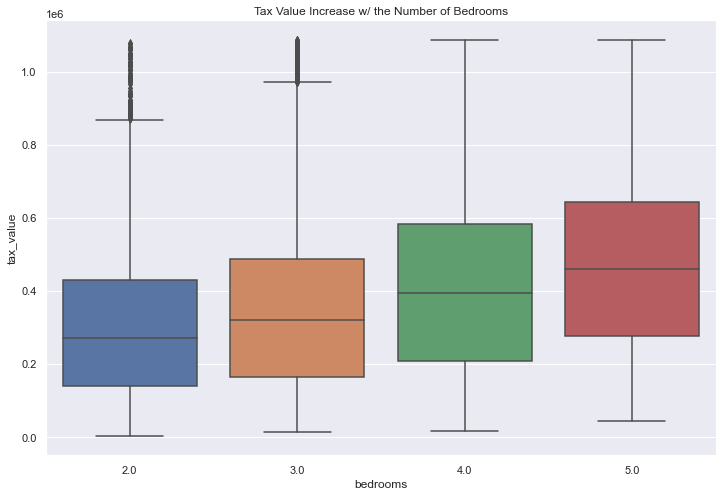

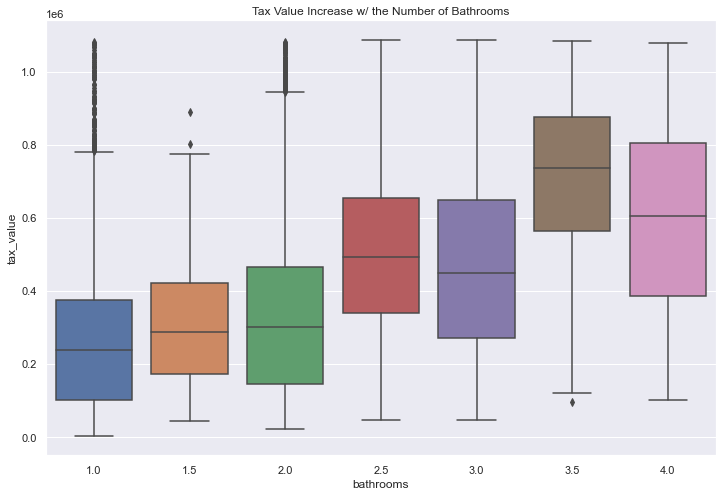

In [29]:
ex.bb_graph(train)

### Takeaways
- It is hard to tell but it seems like bathrooms are more valuable than bedrooms based on visualizations
- Statisitcal testing will need to be done to ensure if this is true.

#### Bed & Bath statistical testing
(H_0): Homes with above the median amount of bathrooms and below the median amount of bedrooms are cheaper then the opposite. \
(H_a): Homes with above the median amonut of bathrooms and below the median amount of bedrooms are more expensive then the opposite.

In [30]:
ex.bb_test(train)

Reject the Null Hypothesis.
        
Homes with above the median amonut of bathrooms and below the median amount of bedrooms are more expensive then the opposite.


<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

# MVP Modeling



#### For the first iteration of my model i am going to use 'sqft', 'bedrooms', and 'bathrooms'

In [31]:
mvp_X_train_scaled, mvp_X_validate_scaled,mvp_X_test_scaled,  X_train, y_train, X_validate, y_validate, X_test, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = md.scale_data(train, validate, test, 'tax_value')

In [32]:
md.run_da_stuff(mvp_X_train_scaled,y_train,mvp_X_validate_scaled,y_validate)

,model,rmse_train,r2_train,rmse_validate,r2_validate
0,baseline_mean,237075.346573,0.000000,232759.041524,0.000000
1,Linear Regression,213000.908055,0.192783,207785.514938,0.203043
2,"LarsLasso, alpha 4",213005.625367,0.192748,207786.931218,0.203032
3,Tweedie Regressor,213000.908055,0.192783,207785.514938,0.203043


## MVP Modeling takeaways

- The Linear Regressor regression model performed best with a $213,00 RMSE and a .192 R2 value for the train dataset and a $207,785 RMSE, .203 R2 value for the validate dataset.

- Let's see if adding more features will create a better model.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

#### Using a correlation heatmap to see which features correlate most to the target, 'tax_value'.

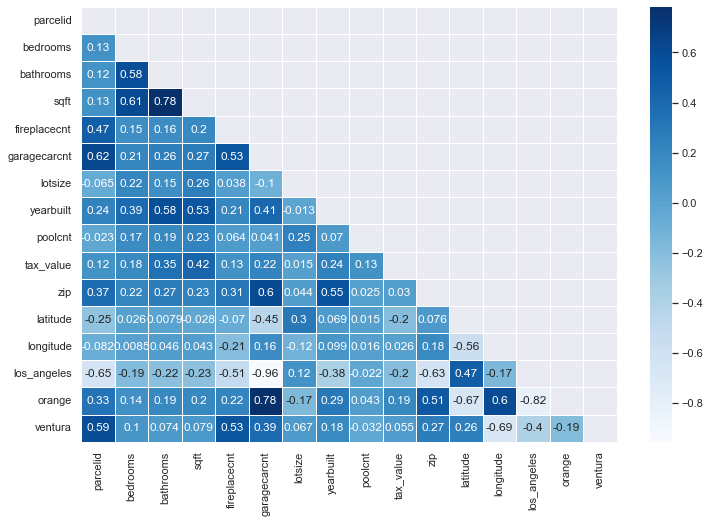

In [33]:
md.corr_graph()

In [34]:
X_train_scaled.head()

,bedrooms,sqft,lotsize,yearbuilt,poolcnt,latitude,longitude
12664,0.666667,0.283679,0.348147,0.127451,0.0,0.496314,0.583621
51907,0.000000,0.141192,0.498308,0.382353,0.0,0.627463,0.465719
47623,0.333333,0.207254,0.330246,0.303922,0.0,0.405553,0.631200
18416,0.333333,0.043718,0.339241,0.039216,0.0,0.437096,0.613345
41471,0.333333,0.200130,0.444514,0.343137,0.0,0.622205,0.692121


In [35]:
md.run_da_stuff(X_train_scaled,y_train,X_validate_scaled,y_validate)

,model,rmse_train,r2_train,rmse_validate,r2_validate
0,baseline_mean,237075.346573,0.000000,232759.041524,0.000000
1,Linear Regression,205837.687620,0.246164,200559.517192,0.257516
2,"LarsLasso, alpha 4",205848.314489,0.246086,200561.600437,0.257500
3,Tweedie Regressor,205837.687620,0.246164,200559.517068,0.257516


In [36]:
md.test_tester(X_train_scaled,y_train,X_validate_scaled,y_validate,X_test_scaled,y_test)

,r2,rmse
test,0.246023,203307.570277


## Modeling takeaways

- The Tweedie Regressor regression model performed best with a \$205,837 RMSE deviation and a .246 R<sup>2</sup> for the train dataset and a \$200,559 RMSE, .257 R<sup>2</sup> value for the validate dataset.
- For the test dataset the model performs a little worse, with a drop off of $3,000.
- Perhaps different features or different types of Regression models would create a better predicting model.

<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px"></hr>

## Conclusions and Next Steps

- The model chosen has beat the baseline by roughly $35,000

- The largest driver for housing prices was square footage followed by location.

- Following this initial project, I would like to create a more refined model. Whether it is through running different groups of features through my current model, tuning the hyperparameters or both.
- As well as creating more python files that store functions so as to make the final report less filled by code and easier to read.
- Create a feature that clusters locations in the dataset, most home prices fluctuate by location within cities. With certain city locations being higher in crime, less wealthy, under developed, etc.
- Include previous assesments of the porperties to see if previous pricing of properties affect sell price.